In [1]:
import h5py

/home/pawel/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import numpy as np

In [18]:
import matplotlib as mpl
from matplotlib.colors import LogNorm

In [4]:
import matplotlib.pyplot as plt

In [5]:
%matplotlib inline

In [6]:
phad = '/home/pawel/Work/PIConGPU/159_FixPhaseSpaceMomentumMetaData/simOutput/h5/'

In [7]:
!ls $phad

simData_0.h5	 simData_2250.h5  simData_3500.h5  simData_5000.h5
simData_1000.h5  simData_2500.h5  simData_3750.h5  simData_500.h5
simData_1250.h5  simData_250.h5   simData_4000.h5  simData_750.h5
simData_1500.h5  simData_2750.h5  simData_4250.h5
simData_1750.h5  simData_3000.h5  simData_4500.h5
simData_2000.h5  simData_3250.h5  simData_4750.h5


In [61]:
f = h5py.File(phad + 'simData_5000.h5')

In [13]:
print(list(f['/data/5000/fields']))

['B', 'C_boundElectronDensity', 'C_chargeDensity', 'C_density', 'C_energyDensity', 'E', 'H_boundElectronDensity', 'H_chargeDensity', 'H_density', 'H_energyDensity', 'J', 'N_boundElectronDensity', 'N_chargeDensity', 'N_density', 'N_energyDensity', 'e_chargeDensity', 'e_density', 'e_energyDensity']


In [62]:
n_e_h5py = f['/data/5000/fields/e_density']

In [63]:
n_e = n_e_h5py.value * n_e_h5py.attrs['unitSI']

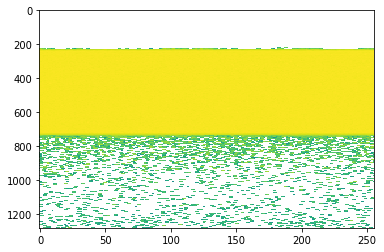

In [93]:
plt.imshow(n_e, norm = LogNorm(), aspect='auto')

In [70]:
B_x_h5py = f['data/5000/fields/B/x']
B_y_h5py = f['data/5000/fields/B/y']
B_z_h5py = f['data/5000/fields/B/z']

In [71]:
B_x = B_x_h5py.value * B_x_h5py.attrs['unitSI']
B_y = B_y_h5py.value * B_y_h5py.attrs['unitSI']
B_z = B_z_h5py.value * B_z_h5py.attrs['unitSI']

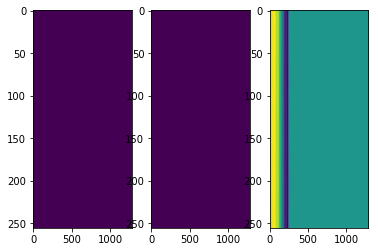

In [72]:
fig, axis = plt.subplots(1,3)
axis[0].imshow(B_x.T, aspect='auto')
axis[1].imshow(B_y.T, aspect='auto')
axis[2].imshow(B_z.T, aspect='auto')

In [76]:
B_z.nonzero()

(array([   0,    0,    0, ..., 1279, 1279, 1279]),
 array([  0,   1,   2, ..., 253, 254, 255]))

In [77]:
J_x_h5py = f['data/5000/fields/J/x']
J_y_h5py = f['data/5000/fields/J/y']
J_z_h5py = f['data/5000/fields/J/z']

In [78]:
J_x = J_x_h5py.value * J_x_h5py.attrs['unitSI']
J_y = J_y_h5py.value * J_y_h5py.attrs['unitSI']
J_z = J_z_h5py.value * J_z_h5py.attrs['unitSI']

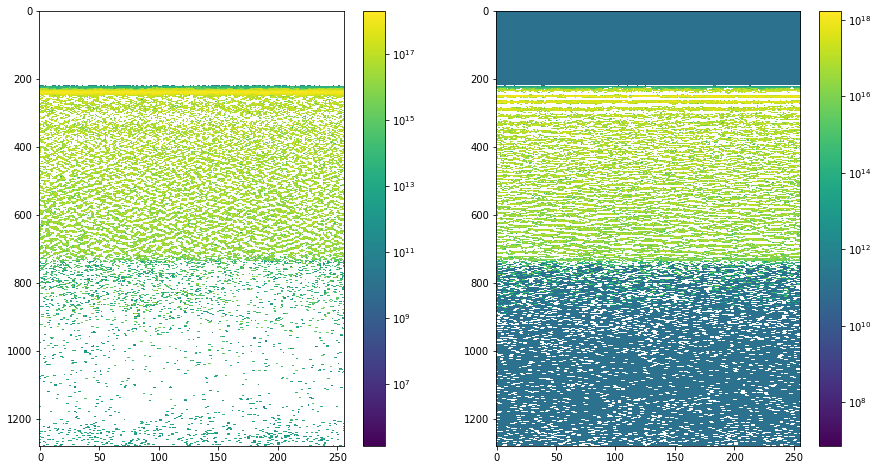

In [92]:
fig, axis = plt.subplots(1,2, figsize=(15,8))
axis[0].imshow(J_x, norm=LogNorm(), aspect='auto')
axis[1].imshow(J_y, norm=LogNorm(), aspect='auto')
fig.colorbar(axis[0].images[0], ax=axis[0])
fig.colorbar(axis[1].images[0], ax=axis[1])

Laser propagation in y direction (?)


In [96]:
list(J_x_h5py.attrs)

['_class',
 '_size',
 '_start',
 '_global_size',
 '_global_start',
 'position',
 'unitSI']

In [133]:
J_x_h5py.attrs['_global_size']

(256, 1280, 1)

In [130]:
list(f['data/5000/fields'])

['B',
 'C_boundElectronDensity',
 'C_chargeDensity',
 'C_density',
 'C_energyDensity',
 'E',
 'H_boundElectronDensity',
 'H_chargeDensity',
 'H_density',
 'H_energyDensity',
 'J',
 'N_boundElectronDensity',
 'N_chargeDensity',
 'N_density',
 'N_energyDensity',
 'e_chargeDensity',
 'e_density',
 'e_energyDensity']